# ETH Price Prediction with Reddit Sentiment & On-Chain Metrics

In [1]:
import pandas as pd
from io import StringIO
import requests
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import praw
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
import time
from dotenv import load_dotenv
import os

### 1. Load On-Chain Data (manually since csv requires payment)

In [2]:
data = """
date,whale_transfer_count,swap_count,total_volume_usd,total_gas_used
2025-04-09,1606,79089,442232420.6858446,76421465639
2025-04-08,2259,124779,830016422.0837877,130488155384
2025-04-07,3979,144656,1547749576.3270354,130037219374
2025-04-06,1891,107906,1232137903.0913436,131097642722
2025-04-05,780,75186,458875312.39824486,130834125064
2025-04-04,1655,115222,891779058.8731519,130863896942
2025-04-03,1429,115329,878486235.6253107,130147029308
2025-04-02,1470,113500,1125935327.8344889,130682100756
2025-04-01,1529,96745,707867819.1128354,130478561914
2025-03-31,1697,102473,717554946.8292001,130428305724
2025-03-30,787,92589,490677952.7131678,131210503317
2025-03-29,1001,106566,648979990.6291386,130812849104
2025-03-28,1775,118192,1095936652.098836,130531928023
2025-03-27,1277,98177,736831361.2455553,130630850336
2025-03-26,1422,104565,754212139.8902023,130797752237
2025-03-25,1103,98890,691451683.9942648,130403108513
2025-03-24,1545,103263,805935623.5554438,130831705645
2025-03-23,648,79732,393321281.54786456,131480872818
2025-03-22,681,76526,354738659.6844233,131481318142
2025-03-21,1273,93328,659791108.0191333,131332527076
2025-03-20,1354,98552,856071385.3106494,130712861164
2025-03-19,1927,116866,1136965568.6742716,130606298924
2025-03-18,1457,105456,685647598.7427822,130706911905
2025-03-17,1454,102962,754054228.1418308,130889448145
2025-03-16,728,95246,529394423.0711604,131341874766
2025-03-15,880,86753,389136811.56042445,131482252401
2025-03-14,1532,104076,781431217.455365,130988571670
2025-03-13,1760,116487,964934772.1505396,130953543840
2025-03-12,1931,129583,1365220800.905456,130661571809
2025-03-11,2471,145765,1801434820.205475,130205767368
2025-03-10,2923,141500,2403876154.7094827,130612493238
2025-03-09,1193,130440,1272571384.5146742,130900025392
2025-03-08,737,104002,741764045.6203324,130665208191
2025-03-07,1673,136906,1736365609.9731076,130320712237
2025-03-06,1533,124700,1013972165.1555378,130414552136
2025-03-05,1708,125288,1094023738.6718807,130581026068
2025-03-04,2548,156777,2227861404.211435,130545084240
2025-03-03,3465,142657,1753314134.878279,130595220001
2025-03-02,3583,117762,1784530890.7620935,131363322546
2025-03-01,2142,102969,788160678.1108052,131036692988
2025-02-28,3333,153896,2217625597.2128186,130605372774
2025-02-27,2731,128615,1074795628.7420273,130711016482
2025-02-26,3075,130876,1550253082.3803816,130799662470
2025-02-25,3341,162158,2178491201.2156425,130130348768
2025-02-24,2503,141486,2077507401.521568,130773714063
2025-02-23,1413,107120,1079950969.0209694,131033118457
2025-02-22,1713,107740,905536425.8371944,130697243064
2025-02-21,2193,124585,1872428058.2677996,130492093998
2025-02-20,1323,108465,863510042.3999292,129975901744
2025-02-19,1413,118045,832262359.3534588,130430372308
2025-02-18,1795,140574,1373249614.165756,130179514094
2025-02-17,1416,117613,1282792346.587433,129947498213
2025-02-16,759,96557,535690325.13189644,130525921517
2025-02-15,872,94293,465286138.04774755,130273141363
2025-02-14,1607,118401,1168601081.2770617,129719329692
2025-02-13,1751,114591,1198099737.1653852,129916998449
2025-02-12,1569,121870,1655820259.5798216,129751611918
2025-02-11,1489,119421,1137838180.706682,130048370024
2025-02-10,1332,126716,1088694055.9127421,130046851591
2025-02-09,1092,112662,859733408.5694622,130617991303
2025-02-08,1384,105128,748739000.418257,130338033098
2025-02-07,1909,133061,1569406808.0683022,130259221353
2025-02-06,2174,121609,1703038287.6187341,130168022751
2025-02-05,2123,121377,1391539615.2972991,130035728535
2025-02-04,2976,142015,2176494347.7321854,126121006227
2025-02-03,5701,138510,4414905574.1786585,110938168934
2025-02-02,1952,126728,2081552367.9374,109773880128
2025-02-01,1082,106725,1218883492.1202455,109262375602
2025-01-31,2137,111628,1927885501.671952,109378918031
2025-01-30,1606,106220,1269797145.7332501,108800361795
2025-01-29,1344,107361,1215556481.1051168,108698573015
2025-01-28,1693,98844,1262488315.9519143,108804382561
2025-01-27,2428,113634,2028778733.1576743,108770745038
2025-01-26,906,91786,1088633240.6821136,108853533312
2025-01-25,1093,82975,794621862.375479,108693279134
2025-01-24,1926,88852,1704161074.3067625,108771645455
2025-01-23,2368,92323,2997564860.673211,108716767487
2025-01-22,1959,87143,1554083162.5159724,108511399550
2025-01-21,2624,92060,2527292182.8275084,108455196396
2025-01-20,2642,88946,3961886887.0659184,108420902441
2025-01-19,2521,100078,2957972416.909825,108610040118
2025-01-18,2132,98600,2038091667.422393,108591783632
2025-01-17,1733,92028,1457010358.9794536,108585721792
2025-01-16,1626,90238,1159327301.489141,108522136755
2025-01-15,1617,90547,1243108298.3905592,108530336372
2025-01-14,1403,86858,1043446825.9147394,108379668223
2025-01-13,2221,111571,1846759079.9773602,108418788183
2025-01-12,571,84778,539770061.3572738,108829229174
2025-01-11,607,85849,552930900.3728387,108559300992
2025-01-10,1255,96006,1150902171.4141023,108378828627
2025-01-09,861,40285,648316508.9906818,44834567049
"""

df_onchain = pd.read_csv(StringIO(data), parse_dates=["date"])
df_onchain.set_index("date", inplace=True)
print(df_onchain.shape)
df_onchain.head()


(91, 4)


,whale_transfer_count,swap_count,total_volume_usd,total_gas_used
date,,,,
2025-04-09,1606,79089,4.422324e+08,76421465639
2025-04-08,2259,124779,8.300164e+08,130488155384
2025-04-07,3979,144656,1.547750e+09,130037219374
2025-04-06,1891,107906,1.232138e+09,131097642722
2025-04-05,780,75186,4.588753e+08,130834125064


### 2. Fetch Reddit Posts via PRAW (Reddit API)

In [3]:
load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("REDDIT_CLIENT_ID"),
    client_secret=os.getenv("REDDIT_CLIENT_SECRET"),
    user_agent=os.getenv("REDDIT_USER_AGENT", "crypto sentiment script")
)

# Top posts from last month
subreddit_name = "CryptoCurrency"
posts = []

for submission in reddit.subreddit(subreddit_name).top(time_filter="month", limit=500):
    title = submission.title
    selftext = submission.selftext or ""
    combined = title + " " + selftext
    created = datetime.utcfromtimestamp(submission.created_utc).date()

    posts.append({
        "date": created,
        "text": combined
    })

reddit_df = pd.DataFrame(posts)
print(f"Fetched {len(reddit_df)} posts")

# VADER Sentiment
analyzer = SentimentIntensityAnalyzer()
reddit_df["sentiment"] = reddit_df["text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

# Aggregation daily
daily_sentiment = reddit_df.groupby("date")["sentiment"].mean().reset_index()
daily_sentiment.columns = ["date", "avg_sentiment"]
print(daily_sentiment.head())


/var/folders/60/_py15qt17v56b8mrbggcwgzr0000gn/T/ipykernel_15477/2358693866.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  created = datetime.utcfromtimestamp(submission.created_utc).date()


Fetched 500 posts
         date  avg_sentiment
0  2025-03-10      -0.142586
1  2025-03-11       0.015433
2  2025-03-12       0.003862
3  2025-03-13       0.037458
4  2025-03-14      -0.168269


### 3. Fetch ETH Price from CoinGecko

In [4]:
def fetch_eth_price(days=90):
    url = f"https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    params = {"vs_currency": "usd", "days": days}
    r = requests.get(url, params=params)
    prices = r.json()["prices"]

    return pd.DataFrame(
        [(datetime.utcfromtimestamp(p[0] / 1000).date(), p[1]) for p in prices],
        columns=["date", "eth_price"]
    )

eth_price_df = fetch_eth_price()
eth_price_df = eth_price_df.groupby("date").mean().reset_index()
eth_price_df.head()


/var/folders/60/_py15qt17v56b8mrbggcwgzr0000gn/T/ipykernel_15477/4089554161.py:8: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  [(datetime.utcfromtimestamp(p[0] / 1000).date(), p[1]) for p in prices],


,date,eth_price
0,2025-01-09,3227.531611
1,2025-01-10,3270.296211
2,2025-01-11,3262.134774
3,2025-01-12,3269.115382
4,2025-01-13,3131.203490


### 4. Merging Dataframes

In [5]:
# Reset index to merge on date
onchain_df = df_onchain.reset_index()

# Make sure all date columns are datetime type
onchain_df["date"] = pd.to_datetime(onchain_df["date"])
daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"])
eth_price_df["date"] = pd.to_datetime(eth_price_df["date"])


In [6]:
# Merge in Reddit sentiment
combined = onchain_df.merge(daily_sentiment, on="date", how="left")

# Merge in ETH price
combined = combined.merge(eth_price_df, on="date", how="left")

# Fill missing sentiment or price
combined.fillna(method="ffill", inplace=True)

combined.head()


/var/folders/60/_py15qt17v56b8mrbggcwgzr0000gn/T/ipykernel_15477/4163023045.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined.fillna(method="ffill", inplace=True)


,date,whale_transfer_count,swap_count,total_volume_usd,total_gas_used,avg_sentiment,eth_price
0,2025-04-09,1606,79089,4.422324e+08,76421465639,0.361200,1474.042964
1,2025-04-08,2259,124779,8.300164e+08,130488155384,-0.126512,1541.943740
2,2025-04-07,3979,144656,1.547750e+09,130037219374,-0.144695,1536.582459
3,2025-04-06,1891,107906,1.232138e+09,131097642722,-0.079553,1744.342298
4,2025-04-05,780,75186,4.588753e+08,130834125064,-0.125713,1802.550717


### 5. Correlation & Lag Features

In [7]:
combined["sentiment_lag1"] = combined["avg_sentiment"].shift(1)
combined["gas_lag1"] = combined["total_gas_used"].shift(1)
combined.dropna(inplace=True)

print("\nCorrelation with ETH Price:")
print(combined.corr(numeric_only=True)["eth_price"])


Correlation with ETH Price:
whale_transfer_count    0.006162
swap_count             -0.286797
total_volume_usd        0.355847
total_gas_used         -0.709740
avg_sentiment          -0.561095
eth_price               1.000000
sentiment_lag1         -0.585783
gas_lag1               -0.643995
Name: eth_price, dtype: float64


### 6. Simple Linear Regression

In [8]:
X = combined[["sentiment_lag1", "gas_lag1", "total_volume_usd"]]
y = combined["eth_price"]
model = LinearRegression().fit(X, y)
print("\nModel R^2 Score:", model.score(X, y))
print("Model Coefficients:", dict(zip(X.columns, model.coef_)))


Model R^2 Score: 0.7149366191782938
Model Coefficients: {'sentiment_lag1': np.float64(-2872.0053039282043), 'gas_lag1': np.float64(-3.054070147651564e-08), 'total_volume_usd': np.float64(3.039763493146714e-08)}


### 7. Visualization

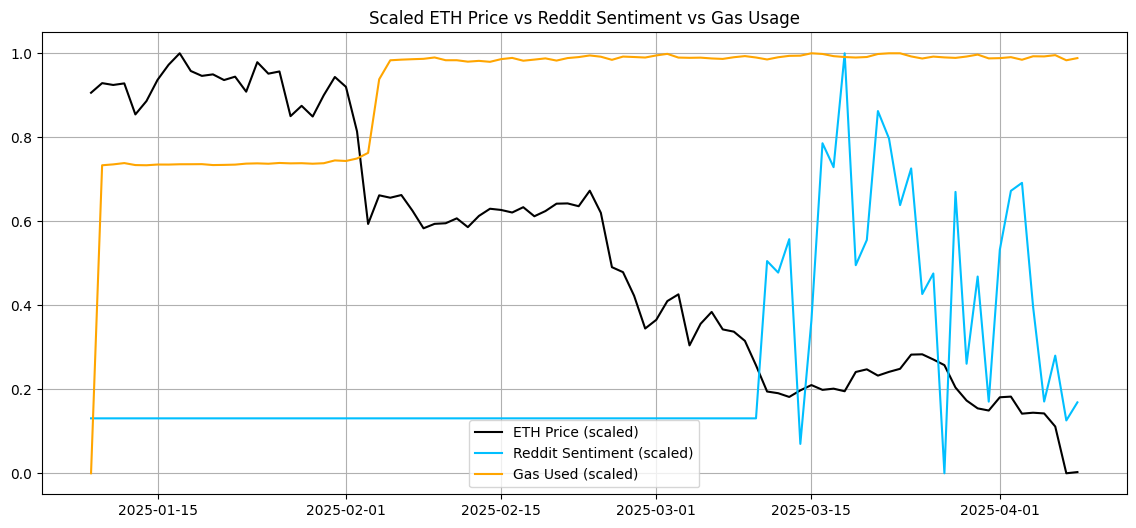

In [9]:
from sklearn.preprocessing import MinMaxScaler

scale_cols = ["eth_price", "avg_sentiment", "total_gas_used"]
scaled_data = combined.dropna(subset=scale_cols).copy()

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(scaled_data[scale_cols])
scaled_df = pd.DataFrame(scaled_values, columns=scale_cols, index=scaled_data["date"])

plt.figure(figsize=(14,6))
plt.plot(scaled_df.index, scaled_df["eth_price"], label="ETH Price (scaled)", color="black")
plt.plot(scaled_df.index, scaled_df["avg_sentiment"], label="Reddit Sentiment (scaled)", color="deepskyblue")
plt.plot(scaled_df.index, scaled_df["total_gas_used"], label="Gas Used (scaled)", color="orange")
plt.title("Scaled ETH Price vs Reddit Sentiment vs Gas Usage")
plt.legend()
plt.grid()
plt.show()



### Insights


- **Reddit sentiment is not a bullish signal** — it may reflect lagged optimism or “buy the dip” chatter **after** price falls. This makes it more of a contrarian or reactive indicator.

- **High gas usage may indicate network stress or hype peaks**, which often **precede pullbacks**. This signal showed a strong negative correlation with ETH price.

- **Trading volume has mild predictive value**, but likely needs to be combined with other context like order flow, volatility, or market structure to be useful alone.

- A **simple linear regression model** using just three features — lagged sentiment, lagged gas usage, and trading volume — achieves an **R² of 0.71**, showing strong explanatory power.

This analysis suggests that while sentiment and activity signals are valuable, they must be interpreted contextually — and may be more powerful when combined or lagged.

